# Aim

Build and analyze a Kalman filter on real SEAL data, in particular to notch out the natural frequency at 17 Hz.

In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import numpy as np
from scipy.signal import welch, windows
from scipy.stats import normaltest, chi2
from scipy.stats import multivariate_normal as mvn
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("..")
from src.utils import genpsd
from src.controllers import SystemIdentifier
from src.controllers import design_filt, filt, design_from_ol
rms = lambda data: np.sqrt(np.mean((data - np.mean(data)) ** 2))

Running in simulation mode.
Recomputed interaction matrix and command matrix


/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:109: UserWarning: Exposure time in sim optics is not used yet.
  warnings.warn("Exposure time in sim optics is not used yet.")
/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:117: UserWarning: Image propagation from the DM has not been implemented.
  warnings.warn("Image propagation from the DM has not been implemented.")


In [4]:
ol = np.load("../data/tt_center_noise/tt_center_noise_nsteps_10000_delay_0.01_dt_21_07_2021_12.npy")

In [43]:
ident = SystemIdentifier(ol, fs=100, N_vib_max=1)
params, variances, _ = ident.vibe_fit_freq(0)
klv = ident.make_klqg_vibe(params, variances * 1e11) # reset variances somehow
params, variances, _ = ident.vibe_fit_freq(1)
klv = klv.concat(ident.make_klqg_vibe(params, variances * 1e11))
# klt = ident.make_klqg_ar()

Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.


In [94]:
klv.A

array([[ 0.94154541, -0.97488067,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.94028951, -0.97228166],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

In [44]:
ol.shape

(10000, 2)

In [46]:
measurements = ol + np.random.normal(0, 0.01, size=ol.shape)
states_v = klv.run_filter(measurements, np.zeros(klv.state_size,))

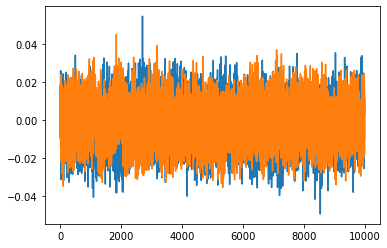

In [48]:
plt.plot(states_v @ klv.C.T)

In [50]:
res2 = ol - (states_v @ klv.C.T)

In [51]:
rms(res2)

0.00997496119619777

In [54]:
res2.shape

(10000, 2)

In [65]:
f, p = genpsd(ol[:,0], dt=0.01)
fres2, pres2 = genpsd(res2[:,0], dt=0.01)

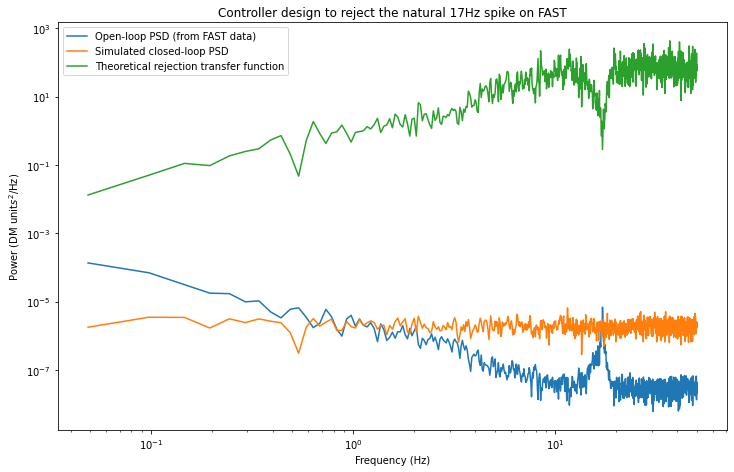

In [66]:
plt.figure(figsize=(12,7.5))
plt.loglog(f, p, label="Open-loop PSD (from FAST data)")
plt.loglog(fres2, pres2, label="Simulated closed-loop PSD")
plt.loglog(fres2, pres2/p, label="Theoretical rejection transfer function")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Power (DM unit$s^2$/Hz)")
plt.title("Controller design to reject the natural 17Hz spike on FAST")
plt.savefig("../plots/rtf_vibe.png")

In [77]:
nsteps = 10000
process_dist = mvn(cov=klv.W, allow_singular=True)
measure_dist = mvn(cov=klv.V, allow_singular=True)

In [86]:
states_un = np.zeros((nsteps, klv.state_size))
states_un[0,:] = 100 * process_dist.rvs()
for i in range(1, nsteps):
    states_un[i,:] = klv.A @ states_un[i-1,:] + process_dist.rvs()
    
rms(states_un @ klv.C.T)

1.4671337016633417

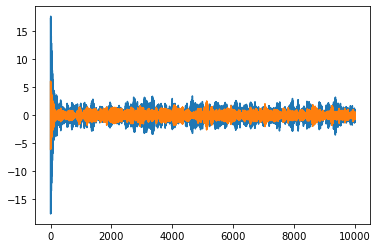

In [84]:
plt.plot(states_un @ klv.C.T)

In [93]:
states = np.zeros((nsteps, klv.state_size))
states_hat = np.zeros((nsteps, klv.state_size))
states[0,:] = states_un[0,:]
states_hat[0,:] = states_un[0,:]
for i in range(1, nsteps):
    x = states[i-1,:]
    x_hat = states_hat[i-1,:]
    u = -klv.L @ x_hat
    y = klv.C @ (klv.A @ x + klv.B @ u) + measure_dist.rvs()
    innovation = y - klv.C @ (klv.A @ x_hat + klv.B @ u)
    states_hat[i,:] = klv.A @ x_hat + klv.B @ u + klv.K @ innovation
    states[i,:] = states[i,:] + process_dist.rvs()
    
rms(states @ klv.C.T)

0.3026071652967418